# Deepfake Detection with MViTv2

## Problem Statement
Deepfakes are AI-generated fake images and videos where human faces are manipulated or synthesized.  
They pose serious risks in misinformation, fraud, privacy invasion, and trust in digital media.  
Detecting deepfakes is challenging because the artifacts are subtle and can vary depending on the generation technique and compression level.

## Project Goal
The goal of this project is to build a prototype deepfake detection system using **Multiscale Vision Transformer v2 (MViTv2)** as the backbone.  
The system will classify face images into two categories:
- **Real**
- **Fake**

## Success Criteria
- Train and evaluate MViTv2 on a dataset of real vs fake faces (train/val/test splits provided).  
- Achieve strong performance on **validation and test sets** using metrics such as:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - ROC-AUC
- Demonstrate robustness to image compression and variations in data.  
- Provide visualization and explainability (e.g., heatmaps) to show how the model distinguishes real from fake.  
- Document the full pipeline (dataset, preprocessing, model, results, discussion) according to assignment requirements.

# Create and activate conda environment

In [17]:
# Create and activate conda environment

# conda create -n deepfake python=3.10 -y
# conda activate deepfake

# Core deep learning stack
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Vision Transformer models (includes MViTv2)
# pip install timm

# Image processing
# pip install opencv-python pillow albumentations

# Utilities
# pip install matplotlib pandas scikit-learn tqdm

# Explainability (optional for Grad-CAM)
# pip install torchcam

# Jupyter Notebook
# pip install notebook ipykernel
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
# python -m ipykernel install --user --name=deepfake --display-name "Python (deepfake)"

# Environment Check

In [18]:
import torch
import timm

print("PyTorch version:", torch.__version__)
print("Torchvision version:", __import__("torchvision").__version__)
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2))
else:
    print("⚠️ CUDA not available, training will be very slow.")

PyTorch version: 2.7.1+cu118
Torchvision version: 0.22.1+cu118
Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
VRAM (GB): 4.0


# Dataset Sanity Check

In [6]:
import os
from pathlib import Path

# go up from notebooks/ into project root
dataset_root = Path("..") / "data" / "raw"
print(dataset_root.resolve())

splits = ["train", "val", "test"]
classes = ["real", "fake"]

summary = {}

for split in splits:
    summary[split] = {}
    for cls in classes:
        folder = dataset_root / split / cls
        if not folder.exists():
            print(f"⚠️ Missing folder: {folder}")
            continue
        count = len([f for f in folder.glob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"]])
        summary[split][cls] = count

# Print summary
print("Dataset Summary (image counts):\n")
for split in splits:
    if split in summary:
        real_count = summary[split].get("real", 0)
        fake_count = summary[split].get("fake", 0)
        total = real_count + fake_count
        print(f"{split.upper():5} | Real: {real_count:,} | Fake: {fake_count:,} | Total: {total:,}")

C:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\raw
Dataset Summary (image counts):

TRAIN | Real: 70,001 | Fake: 70,001 | Total: 140,002
VAL   | Real: 19,787 | Fake: 19,641 | Total: 39,428
TEST  | Real: 5,413 | Fake: 5,492 | Total: 10,905


# Generate Manifest CSVs

In [7]:
# Cell: Re-generate manifests with project-root relative paths (data/raw/...)
import pandas as pd
from pathlib import Path

# Project root is one level above the notebooks folder
project_root = Path.cwd().parent                  
dataset_root = project_root / "data" / "raw"      
manifest_root = project_root / "data" / "manifests"
manifest_root.mkdir(parents=True, exist_ok=True)

splits = ["train", "val", "test"]
classes = {"real": 0, "fake": 1}
valid_exts = {".jpg", ".jpeg", ".png"}

for split in splits:
    rows = []
    for cls_name, cls_label in classes.items():
        folder = dataset_root / split / cls_name
        for img_path in folder.glob("*"):
            if img_path.suffix.lower() in valid_exts:
                # Save path relative to project root, e.g. data/raw/train/real/img.jpg
                rel_to_root = img_path.relative_to(project_root)
                rows.append({"path": str(rel_to_root), "label": cls_label})
    df = pd.DataFrame(rows)
    out_file = manifest_root / f"{split}.csv"
    df.to_csv(out_file, index=False)
    print(f"{split}.csv saved with {len(df)} entries → {out_file}")

train.csv saved with 140002 entries → c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\manifests\train.csv
val.csv saved with 39428 entries → c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\manifests\val.csv
test.csv saved with 10905 entries → c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\manifests\test.csv


# Quick Manifest Review

First 5 rows of train.csv:


,path,label
0,data\raw\train\real\real_0.jpg,0
1,data\raw\train\real\real_1.jpg,0
2,data\raw\train\real\real_10.jpg,0
3,data\raw\train\real\real_100.jpg,0
4,data\raw\train\real\real_1000.jpg,0


Opening: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\raw\train\fake\fake_50275.jpg
Opening: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\raw\train\fake\fake_39190.jpg
Opening: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\raw\train\fake\fake_8044.jpg
Opening: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\data\raw\train\real\real_29481.jpg


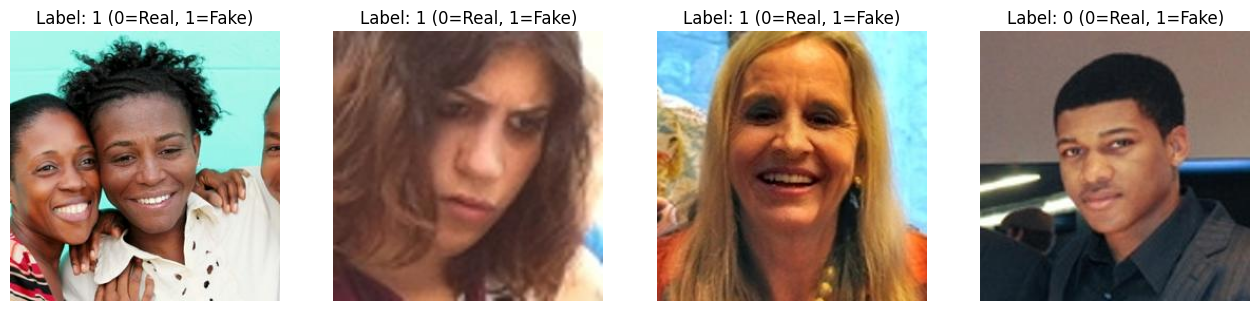

In [8]:
# Cell: Clean preview after re-gen
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

manifest_path = Path("..") / "data" / "manifests" / "train.csv"
df = pd.read_csv(manifest_path)

print("First 5 rows of train.csv:")
display(df.head())

project_root = Path.cwd().parent
sample_df = df.sample(4, random_state=42)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = project_root / row["path"]  # now starts with data/raw/...
    print("Opening:", img_path)
    img = cv2.imread(str(img_path))
    if img is None:
        print("⚠️ Could not load image:", img_path)
        ax.axis("off")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(f"Label: {row['label']} (0=Real, 1=Fake)")
    ax.axis("off")

plt.show()

# Preprocessing and Augmentations

Config (paths, image & aug settings)

In [9]:
# Preprocessing / Augmentations: Config
from pathlib import Path

cfg = {
    "project_root": Path.cwd().parent,          # ...\deepfakeDetection-mvitv2
    "img_size": 224,
    "mean": [0.485, 0.456, 0.406],              # ImageNet stats (MViTv2 pretrain)
    "std":  [0.229, 0.224, 0.225],
    "augment": {
        "hflip_p": 0.5,                         # horizontal flip
        "color_jitter": {"brightness": 0.10, "contrast": 0.10, "saturation": 0.10, "hue": 0.02},
        "jpeg_quality_min": 40,                 # randomized JPEG compression
        "jpeg_quality_max": 95,
        "gaussian_blur_p": 0.15,                # light blur
        "gaussian_noise_p": 0.15,               # light noise
    },
}

Define transforms (Albumentations)

In [10]:
# Build transforms that adapt to your Albumentations version
import albumentations as A
from albumentations.pytorch import ToTensorV2

def make_compression_transform(cfg):
    """Return an image compression transform compatible with the installed Albumentations version, or None."""
    qmin = cfg["augment"]["jpeg_quality_min"]
    qmax = cfg["augment"]["jpeg_quality_max"]

    # Prefer JpegCompression if available
    if hasattr(A, "JpegCompression"):
        try:
            return A.JpegCompression(quality_lower=qmin, quality_upper=qmax, p=1.0)
        except TypeError:
            # Some versions might use different arg names; try 'quality' as a single int if needed
            try:
                return A.JpegCompression(quality=qmin, p=1.0)  # fixed quality fallback
            except Exception:
                pass

    # Try ImageCompression variants
    if hasattr(A, "ImageCompression"):
        # Try common signatures in a safe order
        for kwargs in [
            {"quality_lower": qmin, "quality_upper": qmax, "p": 1.0},
            {"quality_range": (qmin, qmax), "p": 1.0},
            {"quality": qmin, "p": 1.0},  # fixed quality fallback
        ]:
            try:
                return A.ImageCompression(**kwargs)
            except TypeError:
                continue
            except Exception:
                continue

    # As a last resort, try a light blur to mimic compression artifacts
    return A.GaussianBlur(blur_limit=(3, 5), p=1.0)

def make_noise_transform(cfg):
    """Return a noise transform compatible with the installed Albumentations version, or None."""
    p = cfg["augment"]["gaussian_noise_p"]
    if p <= 0:
        return None

    # Prefer ISONoise if available
    if hasattr(A, "ISONoise"):
        try:
            return A.ISONoise(p=p)
        except Exception:
            pass

    # Fallback to GaussNoise if available
    if hasattr(A, "GaussNoise"):
        # Try common signatures
        for kwargs in [
            {"var_limit": (5.0, 20.0), "p": p},
            {"var_limit": (10.0, 50.0), "p": p},
            {"p": p},  # minimal args
        ]:
            try:
                return A.GaussNoise(**kwargs)
            except TypeError:
                continue
            except Exception:
                continue

    # No compatible noise transform found
    return None

def build_train_transforms(cfg):
    s = cfg["img_size"]
    aug = cfg["augment"]
    compression = make_compression_transform(cfg)
    noise = make_noise_transform(cfg)

    transforms = [
        A.Resize(height=s, width=s),
        A.HorizontalFlip(p=aug["hflip_p"]),
        A.ColorJitter(
            brightness=aug["color_jitter"]["brightness"],
            contrast=aug["color_jitter"]["contrast"],
            saturation=aug["color_jitter"]["saturation"],
            hue=aug["color_jitter"]["hue"],
            p=0.4
        ),
        # Compression or blur as a group (probabilistic)
        A.OneOf([
            compression,
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        ], p=0.35) if compression is not None else A.GaussianBlur(blur_limit=(3, 7), p=0.35),
    ]

    if noise is not None:
        transforms.append(noise)

    transforms += [
        A.Normalize(mean=cfg["mean"], std=cfg["std"]),
        ToTensorV2(),
    ]
    return A.Compose(transforms)

def build_eval_transforms(cfg):
    s = cfg["img_size"]
    return A.Compose([
        A.Resize(height=s, width=s),
        A.Normalize(mean=cfg["mean"], std=cfg["std"]),
        ToTensorV2(),
    ])

train_tfms = build_train_transforms(cfg)
val_tfms   = build_eval_transforms(cfg)
test_tfms  = build_eval_transforms(cfg)
print("Transforms (auto-compatible) ready ✅")

Transforms (auto-compatible) ready ✅


C:\Users\gwobe\AppData\Local\Temp\ipykernel_17556\688016308.py:30: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  return A.ImageCompression(**kwargs)


Quick visual check of augmentations

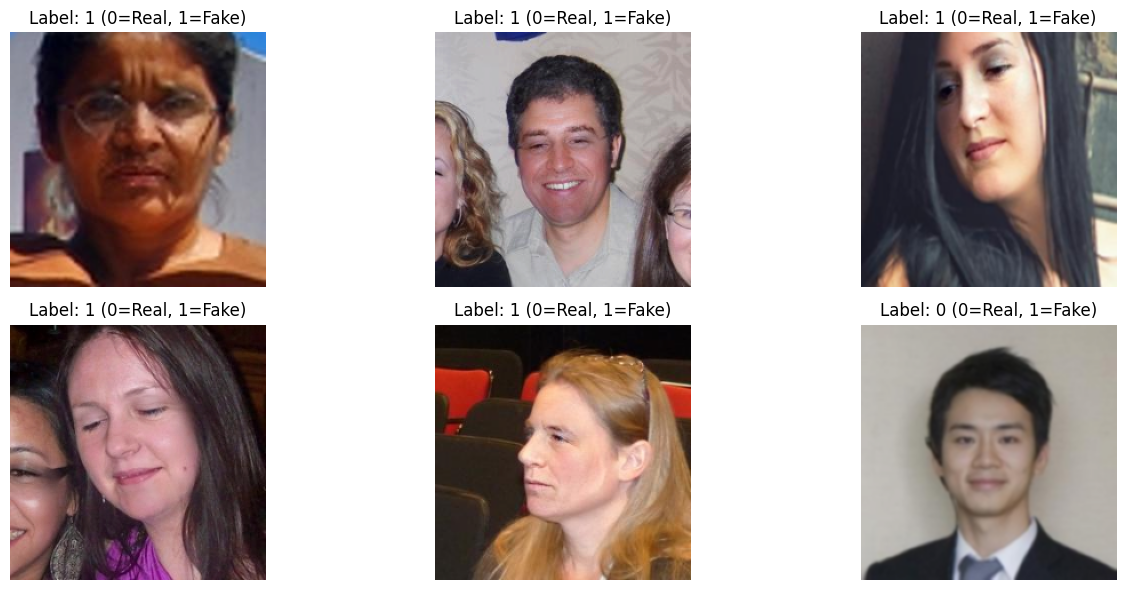

In [11]:
# Preview several augmented samples from train.csv
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import torch

manifest_path = cfg["project_root"] / "data" / "manifests" / "train.csv"
df = pd.read_csv(manifest_path)

# sample N examples to visualize
N = 6
sample_rows = df.sample(N, random_state=123)

fig, axes = plt.subplots(2, (N+1)//2, figsize=(14, 6))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_rows.iterrows()):
    img_path = cfg["project_root"] / row["path"]
    img = cv2.imread(str(img_path))
    if img is None:
        ax.text(0.5, 0.5, "Could not load", ha="center", va="center")
        ax.axis("off")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # apply train transforms (to preview augmentation)
    transformed = train_tfms(image=img)
    timg = transformed["image"]          # torch.Tensor [C,H,W]
    # normalize back to [0,1] for display
    disp = timg.clone()
    disp = disp * torch.tensor(cfg["std"]).view(3,1,1) + torch.tensor(cfg["mean"]).view(3,1,1)
    disp = disp.clamp(0,1).permute(1,2,0).cpu().numpy()

    ax.imshow(disp)
    ax.set_title(f"Label: {row['label']} (0=Real, 1=Fake)")
    ax.axis("off")

# Hide any unused axes
for j in range(len(sample_rows), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Dataset class (CSV + Albumentations)

In [12]:
# Dataset class: reads manifest CSVs and applies Albumentations transforms
from pathlib import Path
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset

class DeepfakeImageDataset(Dataset):
    def __init__(self, csv_path: Path, project_root: Path, transforms=None):
        self.csv_path = Path(csv_path)
        self.project_root = Path(project_root)
        self.df = pd.read_csv(self.csv_path)
        self.transforms = transforms

        # basic integrity check
        if "path" not in self.df.columns or "label" not in self.df.columns:
            raise ValueError(f"{self.csv_path} must contain 'path' and 'label' columns")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.project_root / row["path"]
        label = int(row["label"])

        img = cv2.imread(str(img_path))
        if img is None:
            # if a file is unreadable, you can either raise or skip by retrying a different index
            raise FileNotFoundError(f"Could not read image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            out = self.transforms(image=img)
            img = out["image"]  # torch.Tensor [C,H,W], float32 normalized
        else:
            # minimal fallback (convert to tensor without normalization)
            img = torch.from_numpy(img).permute(2,0,1).float() / 255.0

        return img, torch.tensor(label, dtype=torch.long)

# DataLoaders (batch sizes tuned for 4 GB VRAM)

In [13]:
# DataLoaders for train/val/test
from torch.utils.data import DataLoader

paths = {
    "train": cfg["project_root"] / "data" / "manifests" / "train.csv",
    "val":   cfg["project_root"] / "data" / "manifests" / "val.csv",
    "test":  cfg["project_root"] / "data" / "manifests" / "test.csv",
}

train_ds = DeepfakeImageDataset(paths["train"], cfg["project_root"], transforms=train_tfms)
val_ds   = DeepfakeImageDataset(paths["val"],   cfg["project_root"], transforms=val_tfms)
test_ds  = DeepfakeImageDataset(paths["test"],  cfg["project_root"], transforms=test_tfms)

BATCH_SIZE = 4   # start at 8; drop to 4 if you hit OOM
NUM_WORKERS = 0  # laptop-friendly; you can try 4 if disk is fast

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(140002, 39428, 10905)

Sanity batch (shapes & quick label check)

In [14]:
# Fetch one batch to verify shapes and labels
import torch

xb, yb = next(iter(train_loader))
print("Batch images:", xb.shape)   # [B, 3, 224, 224]
print("Batch labels:", yb.shape, "unique:", torch.unique(yb))

# small VRAM hint
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

Batch images: torch.Size([4, 3, 224, 224])
Batch labels: torch.Size([4]) unique: tensor([0])
GPU available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


# MViTv2 model setup (head-only finetune ready)

In [15]:
# MViTv2 setup with timm (head-only finetune phase prepared)
import timm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pick a compact MViTv2 variant to fit 4 GB VRAM; you can try 'mvitv2_small' later
cfg["model_name"] = "mvitv2_tiny"  # alternatives: 'mvitv2_small'
cfg["num_classes"] = 2
cfg["drop_rate"] = 0.2

# Create model with the correct num_classes
model = timm.create_model(
    cfg["model_name"],
    pretrained=True,
    num_classes=cfg["num_classes"],
    drop_rate=cfg["drop_rate"],
)

# Phase 1: freeze backbone (train head only)
# timm models usually expose classifier as model.get_classifier() or named layer
# We’ll freeze everything except the classifier head parameters.
head_names = set()
# Try to detect classifier module name(s)
if hasattr(model, "get_classifier"):
    head = model.get_classifier()
    # Attempt to find its name by identity scanning
    for name, module in model.named_modules():
        if module is head:
            head_names.add(name)

# Freeze all params first
for p in model.parameters():
    p.requires_grad = False

# Unfreeze head params
if head_names:
    for name, param in model.named_parameters():
        if any(name.startswith(hn) for hn in head_names):
            param.requires_grad = True
else:
    # Fallback: unfreeze last linear layers by common names
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for p in module.parameters():
                p.requires_grad = True

model = model.to(device)

# Print trainable vs total parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {cfg['model_name']}")
print(f"Total params: {total:,} • Trainable (Phase 1): {trainable:,}")

Model: mvitv2_tiny
Total params: 23,405,858 • Trainable (Phase 1): 1,538


# Training config + timestamp helper

In [16]:
# === Phase 1: Head-only training — CONFIG & TIMESTAMP HELPERS ===
from pathlib import Path
from datetime import datetime, timezone

def ts():
    """ISO timestamp for logs/prints."""
    return datetime.now(timezone.utc).astimezone().strftime("%Y-%m-%d %H:%M:%S%z")

# Where to store outputs/checkpoints/metrics
CKPT_DIR   = (cfg["project_root"] / "outputs" / "checkpoints")
METRIC_DIR = (cfg["project_root"] / "outputs" / "metrics")
FIG_DIR    = (cfg["project_root"] / "outputs" / "figures")
for d in [CKPT_DIR, METRIC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Phase-1 training configuration
train_cfg = {
    # core
    "epochs": 8,                 # you can bump later
    "batch_size": 4,             # matches your current loader
    "amp": True,                 # automatic mixed precision
    "grad_accum_steps": 1,       # set >1 to simulate larger effective batch
    "patience": 3,               # EARLY STOPPING on val AUC (enabled in Phase-1 too)

    # optimization
    "lr_head": 1e-3,
    "weight_decay": 1e-2,

    # checkpointing
    "save_last_each_epoch": True,         # <-- save 'last' every epoch
    "last_name": "mvitv2_phase1_last.pt",
    "best_name": "mvitv2_phase1_best.pt",

    # progress display
    "use_tqdm": True,                     # two progress bars: outer (epochs), inner (batches)
    "tqdm_leave": True,
    "tqdm_ncols": 0,                      # auto width
    "tqdm_mininterval": 0.2,             # refresh rate
    "heartbeat_freq": 5000,              # print heartbeat every N steps

    # logging
    "print_every_steps": 0,               # we’ll use tqdm; set >0 to also print every N steps
    "history_file": METRIC_DIR / "phase1_history.json",
}

print(f"[{ts()}] Phase-1 config ready.")
print("Checkpoints dir:", CKPT_DIR)
print("Metrics dir    :", METRIC_DIR)
print("Figures dir    :", FIG_DIR)
print("Early stopping patience (epochs):", train_cfg["patience"])
print("AMP enabled:", train_cfg["amp"])

[2025-09-04 22:12:01+0800] Phase-1 config ready.
Checkpoints dir: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\checkpoints
Metrics dir    : c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\metrics
Figures dir    : c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\figures
Early stopping patience (epochs): 3
AMP enabled: True


# Utils

In [17]:
# === Phase 1: Utils — meters, metrics, checkpointing, history logger ===
import json, math, time
from pathlib import Path
from typing import Dict, Any, Optional
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

# --- simple running average ---
class AvgMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0.0; self.cnt = 0
    def update(self, val: float, n: int = 1):
        self.sum += float(val) * n
        self.cnt += n
    @property
    def avg(self) -> float:
        return self.sum / max(1, self.cnt)

# --- batch metrics from logits (binary) ---
def metrics_from_logits(logits: torch.Tensor, targets_long: torch.Tensor) -> Dict[str, float]:
    """
    logits: [B] raw scores
    targets_long: [B] long {0,1}
    """
    probs = torch.sigmoid(logits.float())
    preds = (probs >= 0.5).long()

    y_true = targets_long.detach().cpu().numpy()
    y_prob = probs.detach().cpu().numpy()
    y_pred = preds.detach().cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float("nan")
    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"acc": acc, "auc": auc, "f1": f1, "precision": pre, "recall": rec}

# --- checkpoint saving ---
def save_checkpoint(
    model: torch.nn.Module,
    optimizer: Optional[torch.optim.Optimizer],
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler],
    scaler: Optional[torch.cuda.amp.GradScaler],
    epoch: int,
    best_val_auc: float,
    path_fixed: Path,
    also_timestamped: bool = True,
):
    """
    Saves a checkpoint to `path_fixed` (e.g., .../mvitv2_phase1_last.pt)
    and optionally a timestamped copy in the same directory.
    """
    ckpt = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer else None,
        "scheduler_state": scheduler.state_dict() if scheduler else None,
        "scaler_state": scaler.state_dict() if scaler else None,
        "epoch": epoch,
        "best_val_auc": best_val_auc,
        "meta": {
            "ts": ts(),
            "model_name": cfg.get("model_name", "?"),
            "num_classes": cfg.get("num_classes", 2),
            "phase": "phase1_head_only",
        },
    }
    path_fixed.parent.mkdir(parents=True, exist_ok=True)
    torch.save(ckpt, path_fixed)

    if also_timestamped:
        stamped = path_fixed.with_name(
            path_fixed.stem.replace(".pt", "") + f"__e{epoch:03d}__{ts().replace(':','-')}.pt"
            if path_fixed.suffix == ".pt"
            else f"{path_fixed.name}__e{epoch:03d}__{ts().replace(':','-')}"
        )
        torch.save(ckpt, stamped)
    return path_fixed

# --- history logger (per-epoch append) ---
def append_history(record: Dict[str, Any], history_file: Path):
    """
    Appends a single epoch record to JSON list file.
    Creates file if missing.
    """
    history_file.parent.mkdir(parents=True, exist_ok=True)
    data = []
    if history_file.exists():
        try:
            with open(history_file, "r") as f:
                data = json.load(f)
            if not isinstance(data, list):
                data = []
        except Exception:
            data = []
    record = {"ts": ts(), **record}
    data.append(record)
    with open(history_file, "w") as f:
        json.dump(data, f, indent=2)
    return record

print(f"[{ts()}] Utils ready: meters/metrics/checkpoint/history.")

[2025-09-04 22:12:06+0800] Utils ready: meters/metrics/checkpoint/history.


# Optimizer/scheduler/AMP scaler setup

In [18]:
# === Phase 1: Optimizer, Scheduler, AMP Scaler ===
import torch
import torch.nn as nn

# Collect only trainable params (head-only phase)
trainable_params = [p for p in model.parameters() if p.requires_grad]
num_trainable = sum(p.numel() for p in trainable_params)
num_total = sum(p.numel() for p in model.parameters())

print(f"[{ts()}] Trainable params (Phase-1): {num_trainable:,} / {num_total:,} total")

optimizer = torch.optim.AdamW(
    trainable_params,
    lr=train_cfg["lr_head"],
    weight_decay=train_cfg["weight_decay"]
)

# Cosine schedule across Phase-1 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=train_cfg["epochs"]
)

# Automatic Mixed Precision scaler
# === Updated GradScaler (new API, fallback to old if needed) ===
try:
    scaler = torch.amp.GradScaler("cuda", enabled=train_cfg["amp"])
    print(f"[{ts()}] Using torch.amp.GradScaler (new API)")
except Exception:
    # fallback for older PyTorch
    scaler = torch.cuda.amp.GradScaler(enabled=train_cfg["amp"])
    print(f"[{ts()}] Using torch.cuda.amp.GradScaler (legacy API)")

print(f"[{ts()}] Optimizer=AdamW(lr={train_cfg['lr_head']}, wd={train_cfg['weight_decay']})")
print(f"[{ts()}] Scheduler=CosineAnnealingLR(T_max={train_cfg['epochs']})")
print(f"[{ts()}] AMP GradScaler enabled={train_cfg['amp']}")

[2025-09-04 22:12:10+0800] Trainable params (Phase-1): 1,538 / 23,405,858 total
[2025-09-04 22:12:10+0800] Using torch.amp.GradScaler (new API)
[2025-09-04 22:12:10+0800] Optimizer=AdamW(lr=0.001, wd=0.01)
[2025-09-04 22:12:10+0800] Scheduler=CosineAnnealingLR(T_max=8)
[2025-09-04 22:12:10+0800] AMP GradScaler enabled=True


# Tqdm-powered inner (batches) and outer (epochs) progress bars
per-epoch last and best checkpoint saving and early stopping

In [32]:
# === PHASE-1 TRAINING (FINAL MERGED) ===
# - Plain-text tqdm (no ipywidgets needed)
# - CrossEntropyLoss for 2-class logits
# - AMP with torch.amp.autocast("cuda")
# - Safe AUC (skip when a batch has one class)
# - Save 'last' checkpoint each epoch + 'best' on AUC improvement
# - Early stopping robust to NaN AUC
#
# Prereqs already defined earlier in your notebook:
# model, device, train_loader, val_loader, optimizer, scheduler, scaler,
# AvgMeter, append_history, CKPT_DIR, train_cfg, ts()

import sys, math, time, json, numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm as TQDM_TXT
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Optional: quick toggles for a short smoke test. Set to None for full run.
LIMIT_STEPS_TRAIN = None   # e.g., 50
LIMIT_STEPS_VAL   = None   # e.g., 20

def _is_better_auc(new_auc: float, best_auc: float) -> bool:
    """Return True if new_auc is a real number and better than best_auc."""
    if new_auc is None or (isinstance(new_auc, float) and math.isnan(new_auc)):
        return False
    return new_auc > best_auc

def metrics_from_logits_mc2(logits: torch.Tensor, targets_long: torch.Tensor):
    """
    logits: [B, 2], targets_long: [B] in {0,1}
    """
    probs1 = torch.softmax(logits.float(), dim=1)[:, 1]  # P(class=1)
    preds  = torch.argmax(logits, dim=1)

    y_true = targets_long.detach().cpu().numpy()
    y_prob = probs1.detach().cpu().numpy()
    y_pred = preds.detach().cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    if np.unique(y_true).size >= 2:
        auc = roc_auc_score(y_true, y_prob)
    else:
        auc = float("nan")
    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"acc": acc, "auc": auc, "f1": f1, "precision": pre, "recall": rec}

def run_train_epoch(model, loader, optimizer, scaler, device="cuda", epoch=1):
    model.train()
    loss_meter = AvgMeter()
    acc_meter  = AvgMeter()
    aucs, f1s  = [], []

    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [train]", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        if LIMIT_STEPS_TRAIN is not None and step > LIMIT_STEPS_TRAIN:
            break

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        with torch.amp.autocast("cuda", enabled=train_cfg["amp"]):
            logits = model(images)                  # [B, 2]
            loss   = F.cross_entropy(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        m = metrics_from_logits_mc2(logits.detach(), labels.detach())
        loss_meter.update(loss.item(), n=labels.size(0))
        acc_meter.update(m["acc"],   n=labels.size(0))
        if not math.isnan(m["auc"]): aucs.append(m["auc"])
        f1s.append(m["f1"])

        inner_bar.set_postfix({
            "loss": f"{loss_meter.avg:.4f}",
            "acc":  f"{acc_meter.avg:.3f}",
            "AUC":  f"{(sum(aucs)/len(aucs)):.3f}" if aucs else "nan",
            "F1":   f"{(sum(f1s)/len(f1s)):.3f}"   if f1s else "nan"
        })
        inner_bar.refresh()                     # force tqdm to redraw every step
        if step % train_cfg.get("heartbeat_freq", 500) == 0:                     # heartbeat every 500 batches
            print(f"[{ts()}] train step {step}/{len(loader)} "
                f"loss={loss_meter.avg:.4f} acc={acc_meter.avg:.3f}", flush=True)

    return {
        "loss": loss_meter.avg,
        "acc":  acc_meter.avg,
        "auc":  float(sum(aucs)/len(aucs)) if aucs else float("nan"),
        "f1":   float(sum(f1s)/len(f1s))   if f1s  else float("nan"),
    }

@torch.no_grad()
def run_val_epoch(model, loader, device="cuda", epoch=1):
    model.eval()
    loss_meter = AvgMeter()
    all_probs, all_labels = [], []

    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [val]  ", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        if LIMIT_STEPS_VAL is not None and step > LIMIT_STEPS_VAL:
            break

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        logits = model(images)                      # [B, 2]
        loss   = F.cross_entropy(logits, labels)
        loss_meter.update(loss.item(), n=labels.size(0))

        probs1 = torch.softmax(logits, dim=1)[:, 1]
        all_probs.append(probs1.cpu())
        all_labels.append(labels.cpu())

        inner_bar.set_postfix({"loss": f"{loss_meter.avg:.4f}"})
        inner_bar.refresh()                     # force tqdm to redraw every step
        if step % train_cfg.get("heartbeat_freq", 500) == 0:                     # heartbeat every 500 batches
            print(f"[{ts()}] val step {step}/{len(loader)} "
                f"loss={loss_meter.avg:.4f}", flush=True)
        

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    if np.unique(all_labels).size >= 2:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = float("nan")
    preds = (all_probs >= 0.5).astype("int64")
    acc   = accuracy_score(all_labels, preds)
    f1    = f1_score(all_labels, preds, zero_division=0)
    pre   = precision_score(all_labels, preds, zero_division=0)
    rec   = recall_score(all_labels, preds, zero_division=0)

    return {"loss": loss_meter.avg, "auc": auc, "acc": acc, "f1": f1, "precision": pre, "recall": rec}

# ====================== MAIN DRIVER ======================
print(f"[{ts()}] === Phase-1 training start ==="); sys.stdout.flush()

best_val_auc = -float("inf")
epochs_no_improve = 0
outer_bar = TQDM_TXT(range(1, train_cfg["epochs"]+1), desc="Training (Phase-1)", ncols=100)

for epoch in outer_bar:
    t0 = time.time()

    train_stats = run_train_epoch(model, train_loader, optimizer, scaler, device=device, epoch=epoch)
    val_stats   = run_val_epoch(model,   val_loader,   device=device, epoch=epoch)
    scheduler.step()

    dt = time.time() - t0
    record = {
        "epoch": epoch, "time_sec": round(dt,1),
        "lr": optimizer.param_groups[0]["lr"],
        "train_loss": train_stats["loss"], "train_acc": train_stats["acc"], "train_auc": train_stats["auc"], "train_f1": train_stats["f1"],
        "val_loss":   val_stats["loss"],   "val_acc":   val_stats["acc"],   "val_auc":   val_stats["auc"],   "val_f1":   val_stats["f1"],
        "val_precision": val_stats["precision"], "val_recall": val_stats["recall"],
    }
    append_history(record, train_cfg["history_file"])

    print(
        f"[{ts()}] Epoch {epoch}/{train_cfg['epochs']} | "
        f"train: loss {train_stats['loss']:.4f} acc {train_stats['acc']:.3f} auc {train_stats['auc']:.3f} f1 {train_stats['f1']:.3f} | "
        f"val:   loss {val_stats['loss']:.4f} acc {val_stats['acc']:.3f} auc {val_stats['auc']:.3f} f1 {val_stats['f1']:.3f} | "
        f"{dt:.1f}s"
    ); sys.stdout.flush()

    # Save 'last' checkpoint every epoch
    if train_cfg.get("save_last_each_epoch", True):
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                        CKPT_DIR / train_cfg["last_name"], also_timestamped=False)

    # Save 'best' checkpoint on AUC improvement (ignore NaN)
    if _is_better_auc(val_stats["auc"], best_val_auc):
        best_val_auc = val_stats["auc"]
        epochs_no_improve = 0
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                        CKPT_DIR / train_cfg["best_name"], also_timestamped=True)
        print(f"  ✅ New best AUC {best_val_auc:.4f} (epoch {epoch})"); sys.stdout.flush()
    else:
        epochs_no_improve += 1
        print(f"  No val AUC improvement ({epochs_no_improve}/{train_cfg['patience']} patience)."); sys.stdout.flush()
        if epochs_no_improve >= train_cfg["patience"]:
            print(f"⛔ Early stopping at epoch {epoch}. Best AUC={best_val_auc:.4f}"); sys.stdout.flush()
            break

print(f"[{ts()}] === Phase-1 training end ==="); sys.stdout.flush()

[2025-09-04 16:44:15+0800] === Phase-1 training start ===


Training (Phase-1):   0%|                                                     | 0/8 [00:00<?, ?it/s]

[2025-09-04 16:48:40+0800] train step 5000/35001 loss=0.5007 acc=0.753


[2025-09-04 16:53:22+0800] train step 10000/35001 loss=0.4915 acc=0.760


[2025-09-04 16:58:01+0800] train step 15000/35001 loss=0.4902 acc=0.763


[2025-09-04 17:02:23+0800] train step 20000/35001 loss=0.4905 acc=0.763


[2025-09-04 17:07:03+0800] train step 25000/35001 loss=0.4897 acc=0.764


[2025-09-04 17:11:36+0800] train step 30000/35001 loss=0.4886 acc=0.764


[2025-09-04 17:16:04+0800] train step 35000/35001 loss=0.4873 acc=0.766


Epoch 1 [train]: 100%|█| 35001/35001 [31:49<00:00, 18.33it/s, loss=0.4873, acc=0.766, AUC=0.851, F1=


[2025-09-04 17:20:53+0800] val step 5000/9857 loss=0.3864


Epoch 1 [val]  : 100%|█████████████████████████████| 9857/9857 [09:47<00:00, 16.78it/s, loss=0.4417]

[2025-09-04 17:25:51+0800] Epoch 1/8 | train: loss 0.4873 acc 0.766 auc 0.851 f1 0.684 | val:   loss 0.4417 acc 0.791 auc 0.878 f1 0.782 | 2496.9s


  ✅ New best AUC 0.8777 (epoch 1)


Training (Phase-1):  12%|█████▏                                   | 1/8 [41:37<4:51:21, 2497.37s/it]

[2025-09-04 17:30:24+0800] train step 5000/35001 loss=0.4873 acc=0.764


[2025-09-04 17:33:50+0800] train step 10000/35001 loss=0.4842 acc=0.768


[2025-09-04 17:37:08+0800] train step 15000/35001 loss=0.4825 acc=0.769


[2025-09-04 17:40:37+0800] train step 20000/35001 loss=0.4833 acc=0.769


[2025-09-04 17:44:00+0800] train step 25000/35001 loss=0.4832 acc=0.770


[2025-09-04 17:49:05+0800] train step 30000/35001 loss=0.4820 acc=0.770


[2025-09-04 17:54:24+0800] train step 35000/35001 loss=0.4819 acc=0.770


Epoch 2 [train]: 100%|█| 35001/35001 [28:32<00:00, 20.44it/s, loss=0.4819, acc=0.770, AUC=0.856, F1=


[2025-09-04 17:59:03+0800] val step 5000/9857 loss=0.4316


Epoch 2 [val]  : 100%|█████████████████████████████| 9857/9857 [09:10<00:00, 17.90it/s, loss=0.4323]

[2025-09-04 18:03:35+0800] Epoch 2/8 | train: loss 0.4819 acc 0.770 auc 0.856 f1 0.688 | val:   loss 0.4323 acc 0.799 auc 0.881 f1 0.797 | 2263.2s


  ✅ New best AUC 0.8814 (epoch 2)


Training (Phase-1):  25%|█████████▊                             | 2/8 [1:19:20<3:55:58, 2359.82s/it]

[2025-09-04 18:08:17+0800] train step 5000/35001 loss=0.4636 acc=0.777


[2025-09-04 18:12:57+0800] train step 10000/35001 loss=0.4701 acc=0.775


[2025-09-04 18:17:33+0800] train step 15000/35001 loss=0.4750 acc=0.773


[2025-09-04 18:22:10+0800] train step 20000/35001 loss=0.4757 acc=0.773


[2025-09-04 18:26:47+0800] train step 25000/35001 loss=0.4756 acc=0.773


[2025-09-04 18:31:23+0800] train step 30000/35001 loss=0.4762 acc=0.773


[2025-09-04 18:35:51+0800] train step 35000/35001 loss=0.4761 acc=0.773


Epoch 3 [train]: 100%|█| 35001/35001 [32:15<00:00, 18.08it/s, loss=0.4761, acc=0.773, AUC=0.857, F1=


[2025-09-04 18:39:06+0800] val step 5000/9857 loss=0.5575


Epoch 3 [val]  : 100%|█████████████████████████████| 9857/9857 [06:23<00:00, 25.71it/s, loss=0.4416]

[2025-09-04 18:42:15+0800] Epoch 3/8 | train: loss 0.4761 acc 0.773 auc 0.857 f1 0.691 | val:   loss 0.4416 acc 0.793 auc 0.884 f1 0.806 | 2319.1s


  ✅ New best AUC 0.8837 (epoch 3)


Training (Phase-1):  38%|██████████████▋                        | 3/8 [1:58:00<3:15:06, 2341.40s/it]

[2025-09-04 18:45:45+0800] train step 5000/35001 loss=0.4742 acc=0.773


[2025-09-04 18:49:18+0800] train step 10000/35001 loss=0.4707 acc=0.776


[2025-09-04 18:52:47+0800] train step 15000/35001 loss=0.4731 acc=0.773


[2025-09-04 18:56:16+0800] train step 20000/35001 loss=0.4734 acc=0.773


[2025-09-04 18:59:46+0800] train step 25000/35001 loss=0.4741 acc=0.773


[2025-09-04 19:03:09+0800] train step 30000/35001 loss=0.4737 acc=0.773


[2025-09-04 19:06:27+0800] train step 35000/35001 loss=0.4726 acc=0.774


Epoch 4 [train]: 100%|█| 35001/35001 [24:12<00:00, 24.10it/s, loss=0.4726, acc=0.774, AUC=0.860, F1=


[2025-09-04 19:09:32+0800] val step 5000/9857 loss=0.5003


Epoch 4 [val]  : 100%|█████████████████████████████| 9857/9857 [06:04<00:00, 27.08it/s, loss=0.4345]


[2025-09-04 19:12:31+0800] Epoch 4/8 | train: loss 0.4726 acc 0.774 auc 0.860 f1 0.691 | val:   loss 0.4345 acc 0.796 auc 0.883 f1 0.802 | 1816.3s
  No val AUC improvement (1/3 patience).


Training (Phase-1):  50%|███████████████████▌                   | 4/8 [2:28:16<2:22:16, 2134.15s/it]

[2025-09-04 19:15:49+0800] train step 5000/35001 loss=0.4644 acc=0.780


[2025-09-04 19:19:10+0800] train step 10000/35001 loss=0.4625 acc=0.782


[2025-09-04 19:22:32+0800] train step 15000/35001 loss=0.4655 acc=0.779


[2025-09-04 19:25:55+0800] train step 20000/35001 loss=0.4636 acc=0.781


[2025-09-04 19:29:26+0800] train step 25000/35001 loss=0.4629 acc=0.781


[2025-09-04 19:32:56+0800] train step 30000/35001 loss=0.4639 acc=0.779


[2025-09-04 19:36:27+0800] train step 35000/35001 loss=0.4636 acc=0.780


Epoch 5 [train]: 100%|█| 35001/35001 [23:55<00:00, 24.38it/s, loss=0.4636, acc=0.780, AUC=0.862, F1=


[2025-09-04 19:39:41+0800] val step 5000/9857 loss=0.5835


Epoch 5 [val]  : 100%|█████████████████████████████| 9857/9857 [06:24<00:00, 25.66it/s, loss=0.4481]

[2025-09-04 19:42:51+0800] Epoch 5/8 | train: loss 0.4636 acc 0.780 auc 0.862 f1 0.696 | val:   loss 0.4481 acc 0.787 auc 0.883 f1 0.803 | 1819.7s


  No val AUC improvement (2/3 patience).


Training (Phase-1):  62%|████████████████████████▍              | 5/8 [2:58:36<1:41:02, 2020.79s/it]

[2025-09-04 19:46:22+0800] train step 5000/35001 loss=0.4669 acc=0.776


[2025-09-04 19:49:53+0800] train step 10000/35001 loss=0.4647 acc=0.778


[2025-09-04 19:53:14+0800] train step 15000/35001 loss=0.4605 acc=0.781


[2025-09-04 19:56:32+0800] train step 20000/35001 loss=0.4602 acc=0.780


[2025-09-04 19:59:50+0800] train step 25000/35001 loss=0.4604 acc=0.780


[2025-09-04 20:03:13+0800] train step 30000/35001 loss=0.4600 acc=0.781


[2025-09-04 20:06:31+0800] train step 35000/35001 loss=0.4596 acc=0.781


Epoch 6 [train]: 100%|█| 35001/35001 [23:39<00:00, 24.66it/s, loss=0.4596, acc=0.781, AUC=0.865, F1=


[2025-09-04 20:09:35+0800] val step 5000/9857 loss=0.5075


Epoch 6 [val]  : 100%|█████████████████████████████| 9857/9857 [06:07<00:00, 26.80it/s, loss=0.4267]


[2025-09-04 20:12:38+0800] Epoch 6/8 | train: loss 0.4596 acc 0.781 auc 0.865 f1 0.699 | val:   loss 0.4267 acc 0.803 auc 0.889 f1 0.811 | 1787.3s
  ✅ New best AUC 0.8892 (epoch 6)


Training (Phase-1):  75%|█████████████████████████████▎         | 6/8 [3:28:24<1:04:43, 1941.52s/it]

[2025-09-04 20:16:09+0800] train step 5000/35001 loss=0.4493 acc=0.786


[2025-09-04 20:19:52+0800] train step 10000/35001 loss=0.4522 acc=0.784


[2025-09-04 20:23:58+0800] train step 15000/35001 loss=0.4536 acc=0.785


[2025-09-04 20:27:49+0800] train step 20000/35001 loss=0.4534 acc=0.785


[2025-09-04 20:31:34+0800] train step 25000/35001 loss=0.4535 acc=0.785


[2025-09-04 20:35:05+0800] train step 30000/35001 loss=0.4521 acc=0.786


[2025-09-04 20:38:37+0800] train step 35000/35001 loss=0.4529 acc=0.786


Epoch 7 [train]: 100%|█| 35001/35001 [25:58<00:00, 22.46it/s, loss=0.4529, acc=0.786, AUC=0.868, F1=


[2025-09-04 20:42:11+0800] val step 5000/9857 loss=0.5209


Epoch 7 [val]  : 100%|█████████████████████████████| 9857/9857 [06:58<00:00, 23.56it/s, loss=0.4272]


[2025-09-04 20:45:36+0800] Epoch 7/8 | train: loss 0.4529 acc 0.786 auc 0.868 f1 0.704 | val:   loss 0.4272 acc 0.801 auc 0.891 f1 0.811 | 1976.9s
  ✅ New best AUC 0.8908 (epoch 7)


Training (Phase-1):  88%|███████████████████████████████████▉     | 7/8 [4:01:21<32:33, 1953.21s/it]

[2025-09-04 20:49:34+0800] train step 5000/35001 loss=0.4454 acc=0.790


[2025-09-04 20:53:13+0800] train step 10000/35001 loss=0.4463 acc=0.790


[2025-09-04 20:56:51+0800] train step 15000/35001 loss=0.4496 acc=0.786


[2025-09-04 21:00:28+0800] train step 20000/35001 loss=0.4508 acc=0.786


[2025-09-04 21:04:03+0800] train step 25000/35001 loss=0.4509 acc=0.786


[2025-09-04 21:07:41+0800] train step 30000/35001 loss=0.4506 acc=0.786


[2025-09-04 21:11:28+0800] train step 35000/35001 loss=0.4505 acc=0.786


Epoch 8 [train]: 100%|█| 35001/35001 [25:52<00:00, 22.55it/s, loss=0.4505, acc=0.786, AUC=0.870, F1=


[2025-09-04 21:14:59+0800] val step 5000/9857 loss=0.5173


Epoch 8 [val]  : 100%|█████████████████████████████| 9857/9857 [06:50<00:00, 24.00it/s, loss=0.4274]


[2025-09-04 21:18:19+0800] Epoch 8/8 | train: loss 0.4505 acc 0.786 auc 0.870 f1 0.703 | val:   loss 0.4274 acc 0.801 auc 0.890 f1 0.811 | 1962.8s
  No val AUC improvement (1/3 patience).


Training (Phase-1): 100%|█████████████████████████████████████████| 8/8 [4:34:04<00:00, 2055.56s/it]

[2025-09-04 21:18:19+0800] === Phase-1 training end ===


# Evaluation (Phase-1 best) - metrics, ROC, confusion matrix, CSV preds

[2025-09-05 16:43:15+0800] Loaded best checkpoint: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\checkpoints\mvitv2_phase1_best.pt


Eval val: 100%|█████████████████████████████████████████████████| 9857/9857 [05:35<00:00, 29.35it/s]


[2025-09-05 16:48:51+0800] VAL — acc 0.8010 | AUC 0.8908 | F1 0.8110 | precision 0.7695 | recall 0.8572 | 39428 imgs in 335.9s (117.4 img/s)


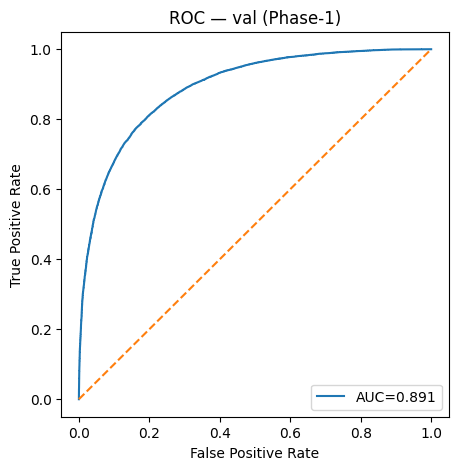

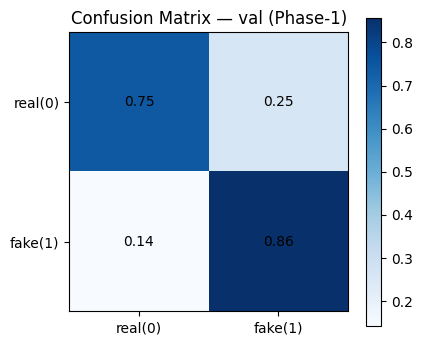

  saved predictions -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\val_preds_phase1.csv

              precision    recall  f1-score   support

     real(0)     0.8402    0.7452    0.7898     19787
     fake(1)     0.7695    0.8572    0.8110     19641

    accuracy                         0.8010     39428
   macro avg     0.8049    0.8012    0.8004     39428
weighted avg     0.8050    0.8010    0.8004     39428

  saved classification report -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\val_classification_report_phase1.csv


Eval test: 100%|████████████████████████████████████████████████| 2727/2727 [01:33<00:00, 29.18it/s]


[2025-09-05 16:50:24+0800] TEST — acc 0.7753 | AUC 0.8639 | F1 0.7887 | precision 0.7493 | recall 0.8325 | 10905 imgs in 93.5s (116.7 img/s)


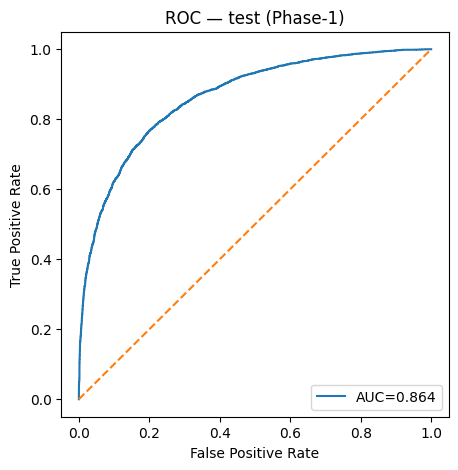

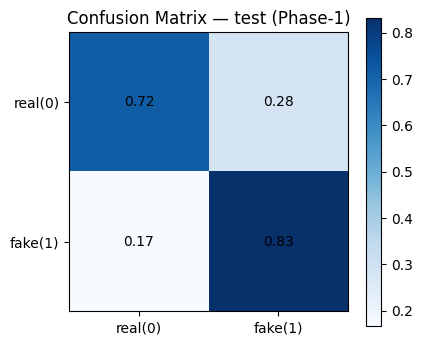

  saved predictions -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\test_preds_phase1.csv

              precision    recall  f1-score   support

     real(0)     0.8085    0.7173    0.7602      5413
     fake(1)     0.7493    0.8325    0.7887      5492

    accuracy                         0.7753     10905
   macro avg     0.7789    0.7749    0.7744     10905
weighted avg     0.7786    0.7753    0.7745     10905

  saved classification report -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\test_classification_report_phase1.csv

[2025-09-05 16:50:25+0800] Done. Summary:
  VAL : {'acc': 0.8009789996956478, 'auc': 0.8907539111608896, 'f1': 0.8110021917676244, 'precision': 0.7695401773471067, 'recall': 0.8571864976325034}
  TEST: {'acc': 0.7753324163227877, 'auc': 0.8639416936029352, 'f1': 0.7886838019665344, 'precision': 0.7492625368731564, 'recall': 0.8324836125273124}


In [41]:
# === EVALUATION (Phase-1 best) — metrics, ROC, confusion matrix, CSV preds ===
from tqdm import tqdm as TQDM_TXT
import torch, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

best_ckpt = CKPT_DIR / train_cfg["best_name"]
assert best_ckpt.exists(), f"Best checkpoint not found: {best_ckpt}"

# Load best weights
ckpt = torch.load(best_ckpt, map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.eval().to(device)
print(f"[{ts()}] Loaded best checkpoint: {best_ckpt}")

def eval_split(split_name, loader, manifest_csv):
    t0 = time.time()
    all_probs, all_labels = [], []
    all_paths = []
    phase_suffix = "phase1"

    with torch.no_grad():
        for step, (images, labels) in enumerate(TQDM_TXT(loader, desc=f"Eval {split_name}", ncols=100), 1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()
            logits = model(images)                      # [B, 2]
            probs1 = torch.softmax(logits, dim=1)[:,1]  # P(fake)
            all_probs.append(probs1.cpu())
            all_labels.append(labels.cpu())

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    if step % 3000 == 0:
        print(f"[{ts()}] {split_name} step {step}/{len(loader)}", flush=True)

    preds = (all_probs >= 0.5).astype("int64")
    acc   = (preds == all_labels).mean()
    if np.unique(all_labels).size >= 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        split_auc   = auc(fpr, tpr)
    else:
        fpr, tpr, split_auc = np.array([0,1]), np.array([0,1]), float("nan")

    f1  = f1_score(all_labels, preds, zero_division=0)
    pre = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    cm  = confusion_matrix(all_labels, preds)

    dt = time.time() - t0
    imgs = len(all_labels)
    print(
        f"[{ts()}] {split_name.upper()} — acc {acc:.4f} | AUC {split_auc:.4f} | F1 {f1:.4f} "
        f"| precision {pre:.4f} | recall {rec:.4f} | {imgs} imgs in {dt:.1f}s ({imgs/dt:.1f} img/s)"
    )

    # Save ROC
    fig_dir = FIG_DIR
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(5,5))
    if not np.isnan(split_auc):
        plt.plot(fpr, tpr, label=f"AUC={split_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {split_name} (Phase-1)")
    plt.legend(loc="lower right")
    roc_path = fig_dir / f"roc_{phase_suffix}_{split_name}.png"
    plt.savefig(roc_path, dpi=120, bbox_inches="tight")
    plt.show()   # <--- display inline
    plt.close()

    # Save confusion matrix (normalized)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm_norm, interpolation='nearest', cmap="Blues")
    plt.title(f"Confusion Matrix — {split_name} (Phase-1)")
    plt.colorbar()
    plt.xticks([0,1], ["real(0)","fake(1)"])
    plt.yticks([0,1], ["real(0)","fake(1)"])
    for (i,j), v in np.ndenumerate(cm_norm):
        plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    cm_path = fig_dir / f"cm_{phase_suffix}_{split_name}.png"
    plt.savefig(cm_path, dpi=120, bbox_inches="tight")
    plt.show()   # <--- display inline
    plt.close()

    # Save per-image predictions CSV
    # Reuse the manifest to attach file paths alongside predictions
    df_manifest = pd.read_csv(manifest_csv)
    # Keep only first len(all_probs) rows if loader truncates (should match)
    df_out = df_manifest.iloc[:len(all_probs)].copy()
    df_out["prob_fake"] = all_probs
    df_out["pred"] = preds
    preds_dir = cfg["project_root"] / "outputs" / "predictions"
    preds_dir.mkdir(parents=True, exist_ok=True)
    csv_path = preds_dir / f"{split_name}_preds_{phase_suffix}.csv"
    df_out.to_csv(csv_path, index=False)
    print(f"  saved predictions -> {csv_path}")

    # Print classification report (text)
    print("\n" + classification_report(all_labels, preds, target_names=["real(0)","fake(1)"], digits=4))

    # Generate dict instead of string
    report_dict = classification_report(all_labels, preds, target_names=["real(0)","fake(1)"], output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    # Save to CSV
    report_path = preds_dir / f"{split_name}_classification_report_{phase_suffix}.csv"
    df_report.to_csv(report_path, float_format="%.4f")
    print(f"  saved classification report -> {report_path}")

    return {"acc":acc, "auc":split_auc, "f1":f1, "precision":pre, "recall":rec}

# Evaluate on VAL
val_csv = cfg["project_root"] / "data" / "manifests" / "val.csv"
val_metrics = eval_split("val", val_loader, val_csv)

# Evaluate on TEST
test_csv = cfg["project_root"] / "data" / "manifests" / "test.csv"
test_metrics = eval_split("test", test_loader, test_csv)

print(f"\n[{ts()}] Done. Summary:")
print("  VAL :", val_metrics)
print("  TEST:", test_metrics)

# Unfreeze last stage + set optimizer with differential LRs

In [26]:
# === Phase 2: partial unfreeze setup (last stage) + differential LRs ===
import torch
import torch.nn as nn

# 1) Unfreeze head (already trainable) + last stage of backbone.
# MViTv2 in timm typically has a 'stages' list-like; we try several common names safely,
# and fall back to unfreezing the last ~25% of non-head parameters if structure differs.

def unfreeze_last_stage_mvitv2(model):
    # always keep head trainable
    if hasattr(model, "get_classifier"):
        head_mod = model.get_classifier()
        for n, m in model.named_modules():
            if m is head_mod:
                for p in m.parameters():
                    p.requires_grad = True

    # try to find a last stage by common names
    candidate_module = None
    for name in ["stages.3", "stages.4", "stage4", "blocks.3", "blocks4", "layer4"]:
        try:
            mod = dict(model.named_modules()).get(name, None)
            if mod is not None:
                candidate_module = mod
                break
        except Exception:
            pass

    if candidate_module is not None:
        for p in candidate_module.parameters():
            p.requires_grad = True
        print("Unfroze last stage:", candidate_module.__class__.__name__)
        return

    # Fallback: unfreeze last ~25% of non-head params by order
    non_head_params = []
    head_params_ids = set(id(p) for p in model.get_classifier().parameters()) if hasattr(model, "get_classifier") else set()
    for n, p in model.named_parameters():
        if id(p) not in head_params_ids:
            non_head_params.append(p)
    k = max(1, int(0.25 * len(non_head_params)))
    for p in non_head_params[-k:]:
        p.requires_grad = True
    print(f"Fallback: unfroze last ~25% of backbone params ({k} tensors).")

# Start from Phase-1 best weights if not already loaded
best_phase1 = CKPT_DIR / train_cfg["best_name"]
if best_phase1.exists():
    ckpt = torch.load(best_phase1, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    print("Loaded Phase-1 best weights for Phase-2.")

# 2) Freeze everything first, then selectively unfreeze
for p in model.parameters():
    p.requires_grad = False
unfreeze_last_stage_mvitv2(model)  # + head

# 3) Build param groups: lower LR for backbone, higher LR for head
backbone_params, head_params = [], []
if hasattr(model, "get_classifier"):
    head_ptrs = set(id(p) for p in model.get_classifier().parameters())
else:
    head_ptrs = set()

for p in model.parameters():
    if not p.requires_grad:
        continue
    (head_params if id(p) in head_ptrs else backbone_params).append(p)

print(f"Trainable Phase-2 — head tensors: {len(head_params)}, backbone tensors: {len(backbone_params)}")
print(f"Trainable params count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 4) Phase-2 config & optimizer/scheduler
train_cfg2 = {
    "epochs": 5,                # 3–5 is typical
    "patience": 2,              # shorter patience for fine-tune
    "amp": True,
    "heartbeat_freq": 3000,    # print heartbeat every N steps

    "lr_head": 5e-4,            # head higher LR
    "lr_backbone": 1e-4,        # backbone lower LR
    "weight_decay": 1e-2,

    "last_name": "mvitv2_phase2_last.pt",
    "best_name": "mvitv2_phase2_best.pt",
}
print("Phase-2 config:", train_cfg2)

# Rebuild optimizer with 2 groups
optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": train_cfg2["lr_backbone"]},
        {"params": head_params,     "lr": train_cfg2["lr_head"]},
    ],
    weight_decay=train_cfg2["weight_decay"],
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_cfg2["epochs"])

# Update scaler (same AMP)
try:
    scaler = torch.amp.GradScaler("cuda", enabled=train_cfg2["amp"])
except Exception:
    scaler = torch.cuda.amp.GradScaler(enabled=train_cfg2["amp"])

print(f"[{ts()}] Phase-2 optimizer ready (backbone lr={train_cfg2['lr_backbone']}, head lr={train_cfg2['lr_head']})")

Loaded Phase-1 best weights for Phase-2.
Unfroze last stage: MultiScaleVitStage
Trainable Phase-2 — head tensors: 2, backbone tensors: 48
Trainable params count: 13,601,474
Phase-2 config: {'epochs': 5, 'patience': 2, 'amp': True, 'heartbeat_freq': 3000, 'lr_head': 0.0005, 'lr_backbone': 0.0001, 'weight_decay': 0.01, 'last_name': 'mvitv2_phase2_last.pt', 'best_name': 'mvitv2_phase2_best.pt'}
[2025-09-04 22:42:34+0800] Phase-2 optimizer ready (backbone lr=0.0001, head lr=0.0005)


# Run Phase-2 (redifine loops)

In [27]:
# Re-define the Phase-2 compatible train/val epoch functions (plain-text tqdm, CE, AMP, safe AUC)
import math, numpy as np, torch, torch.nn.functional as F
from tqdm import tqdm as TQDM_TXT
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

# If missing, adjust these flags via either train_cfg2 or train_cfg
def _amp_enabled():
    return (isinstance(globals().get("train_cfg2", {}), dict) and train_cfg2.get("amp", True)) or \
           (isinstance(globals().get("train_cfg",  {}), dict) and train_cfg.get("amp",  True))

def _heartbeat_freq():
    if isinstance(globals().get("train_cfg2", {}), dict) and "heartbeat_freq" in train_cfg2:
        return train_cfg2["heartbeat_freq"]
    if isinstance(globals().get("train_cfg", {}), dict) and "heartbeat_freq" in train_cfg:
        return train_cfg["heartbeat_freq"]
    return 500  # default

def metrics_from_logits_mc2(logits: torch.Tensor, targets_long: torch.Tensor):
    probs1 = torch.softmax(logits.float(), dim=1)[:, 1]
    preds  = torch.argmax(logits, dim=1)

    y_true = targets_long.detach().cpu().numpy()
    y_prob = probs1.detach().cpu().numpy()
    y_pred = preds.detach().cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if np.unique(y_true).size >= 2 else float("nan")
    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"acc": acc, "auc": auc, "f1": f1, "precision": pre, "recall": rec}

def run_train_epoch(model, loader, optimizer, scaler, device="cuda", epoch=1):
    from time import time
    model.train()
    loss_meter = AvgMeter(); acc_meter = AvgMeter()
    aucs, f1s = [], []

    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [train]", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        with torch.amp.autocast("cuda", enabled=_amp_enabled()):
            logits = model(images)                  # [B, 2]
            loss   = F.cross_entropy(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        m = metrics_from_logits_mc2(logits.detach(), labels.detach())
        loss_meter.update(loss.item(), n=labels.size(0))
        acc_meter.update(m["acc"],   n=labels.size(0))
        if not math.isnan(m["auc"]): aucs.append(m["auc"])
        f1s.append(m["f1"])

        inner_bar.set_postfix({
            "loss": f"{loss_meter.avg:.4f}",
            "acc":  f"{acc_meter.avg:.3f}",
            "AUC":  f"{(sum(aucs)/len(aucs)):.3f}" if aucs else "nan",
            "F1":   f"{(sum(f1s)/len(f1s)):.3f}"   if f1s else "nan"
        })
        inner_bar.refresh()
        if step % _heartbeat_freq() == 0:
            print(f"[{ts()}] train step {step}/{len(loader)} "
                  f"loss={loss_meter.avg:.4f} acc={acc_meter.avg:.3f}", flush=True)

    return {
        "loss": loss_meter.avg,
        "acc":  acc_meter.avg,
        "auc":  float(sum(aucs)/len(aucs)) if aucs else float("nan"),
        "f1":   float(sum(f1s)/len(f1s))   if f1s  else float("nan"),
    }

@torch.no_grad()
def run_val_epoch(model, loader, device="cuda", epoch=1):
    model.eval()
    loss_meter = AvgMeter()
    all_probs, all_labels = [], []

    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [val]  ", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        logits = model(images)                      # [B, 2]
        loss   = F.cross_entropy(logits, labels)
        loss_meter.update(loss.item(), n=labels.size(0))

        probs1 = torch.softmax(logits, dim=1)[:, 1]
        all_probs.append(probs1.cpu())
        all_labels.append(labels.cpu())

        inner_bar.set_postfix({"loss": f"{loss_meter.avg:.4f}"})
        inner_bar.refresh()
        if step % _heartbeat_freq() == 0:
            print(f"[{ts()}] val step {step}/{len(loader)} "
                  f"loss={loss_meter.avg:.4f}", flush=True)

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    auc = roc_auc_score(all_labels, all_probs) if np.unique(all_labels).size >= 2 else float("nan")
    preds = (all_probs >= 0.5).astype("int64")
    acc   = accuracy_score(all_labels, preds)
    f1    = f1_score(all_labels, preds, zero_division=0)
    pre   = precision_score(all_labels, preds, zero_division=0)
    rec   = recall_score(all_labels, preds, zero_division=0)
    return {"loss": loss_meter.avg, "auc": auc, "acc": acc, "f1": f1, "precision": pre, "recall": rec}

# First epoch for Phase 2

In [ ]:
# === Phase 2: run training loop (reusing your existing run_* functions) ===
import time, math, sys

print(f"[{ts()}] === Phase-2 training start ==="); sys.stdout.flush()

best_val_auc = -float("inf")
epochs_no_improve = 0
outer_bar = __import__("tqdm").tqdm(range(1, train_cfg2["epochs"]+1), desc="Training (Phase-2)", ncols=100)

for epoch in outer_bar:
    t0 = time.time()
    train_stats = run_train_epoch(model, train_loader, optimizer, scaler, device=device, epoch=epoch)
    val_stats   = run_val_epoch(model, val_loader,   device=device, epoch=epoch)
    scheduler.step()

    dt = time.time() - t0
    print(
        f"[{ts()}] Epoch {epoch}/{train_cfg2['epochs']} | "
        f"train: loss {train_stats['loss']:.4f} acc {train_stats['acc']:.3f} auc {train_stats['auc']:.3f} f1 {train_stats['f1']:.3f} | "
        f"val:   loss {val_stats['loss']:.4f} acc {val_stats['acc']:.3f} auc {val_stats['auc']:.3f} f1 {val_stats['f1']:.3f} | "
        f"{dt:.1f}s",
        flush=True
    )

    # save last each epoch
    save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                    CKPT_DIR / train_cfg2["last_name"], also_timestamped=False)

    # save best on AUC improve (NaN-safe, same helper from Phase-1 merged cell)
    if '_is_better_auc' in globals():
        is_better = _is_better_auc(val_stats["auc"], best_val_auc)
    else:
        is_better = (not (val_stats["auc"] is None or (isinstance(val_stats["auc"], float) and math.isnan(val_stats["auc"])))) and (val_stats["auc"] > best_val_auc)

    if is_better:
        best_val_auc = val_stats["auc"]
        epochs_no_improve = 0
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                        CKPT_DIR / train_cfg2["best_name"], also_timestamped=True)
        print(f"  ✅ New best AUC {best_val_auc:.4f} (epoch {epoch})", flush=True)
    else:
        epochs_no_improve += 1
        print(f"  No val AUC improvement ({epochs_no_improve}/{train_cfg2['patience']} patience).", flush=True)
        if epochs_no_improve >= train_cfg2["patience"]:
            print(f"⛔ Early stopping at epoch {epoch}. Best AUC={best_val_auc:.4f}", flush=True)
            break

print(f"[{ts()}] === Phase-2 training end ==="); sys.stdout.flush()

Epoch 1 [train]: 100%|█| 35001/35001 [45:38<00:00, 12.78it/s, loss=0.1055, acc=0.958, AUC=0.993, F1=]

[2025-09-04 23:30:22+0800] val step 3000/9857 loss=0.1264

[2025-09-04 23:32:30+0800] val step 6000/9857 loss=0.1125

[2025-09-04 23:34:31+0800] val step 9000/9857 loss=0.0914

Epoch 1 [val]  : 100%|█████████████████████████████| 9857/9857 [06:44<00:00, 24.38it/s, loss=0.0850]

[2025-09-04 23:35:06+0800] Epoch 1/5 | train: loss 0.1055 acc 0.958 auc 0.993 f1 0.888 | val:   loss 0.0850 acc 0.971 auc 0.997 f1 0.971 | 3143.1s

✅ New best AUC 0.9965 (epoch 1)

Pause Phase 2 to check if stats is normal
# Resume Phase-2 training

In [31]:
# === ONE-SHOT STABILITY & DIAGNOSTIC PATCH FOR PHASE-2 RESUME ===
import torch, math, numpy as np
from pathlib import Path

assert "model" in globals() and "optimizer" in globals() and "scheduler" in globals() \
       and "scaler" in globals() and "CKPT_DIR" in globals() and "train_cfg2" in globals(), \
       "Please run your Phase-2 setup first (model/optimizer/scheduler/scaler/CKPT_DIR/train_cfg2)."

last_ckpt_path = CKPT_DIR / train_cfg2["last_name"]
assert last_ckpt_path.exists(), f"Missing checkpoint: {last_ckpt_path}"

# 1) Read resume epoch from last checkpoint and set scheduler.last_epoch to match (prevents LR jump)
ck_last = torch.load(last_ckpt_path, map_location="cpu")
resume_epoch = int(ck_last.get("epoch", 0))
if hasattr(scheduler, "last_epoch"):
    # CosineAnnealingLR expects last_epoch to be the index of the last completed epoch.
    scheduler.last_epoch = resume_epoch - 1 if resume_epoch > 0 else 0

# 2) Verify param groups and ensure LR mapping (group0=backbone, group1=head) per train_cfg2
#    We'll detect head parameters via get_classifier() if available.
head_param_ids = set()
if hasattr(model, "get_classifier") and model.get_classifier() is not None:
    for p in model.get_classifier().parameters():
        head_param_ids.add(id(p))

group0_ids = set(id(p) for p in optimizer.param_groups[0]["params"])
group1_ids = set(id(p) for p in optimizer.param_groups[1]["params"])
head_in_g0 = len(group0_ids & head_param_ids)
head_in_g1 = len(group1_ids & head_param_ids)

print(f"[diag] param_groups sizes: {[len(g['params']) for g in optimizer.param_groups]}")
print(f"[diag] head params in groups -> g0:{head_in_g0} g1:{head_in_g1}")

# If head params mostly live in group1 (expected), assign LR: g0=backbone, g1=head
# If not, we still force LRs by convention; if composition is wrong, consider rebuilding optimizer later.
optimizer.param_groups[0]["lr"] = float(train_cfg2["lr_backbone"])
optimizer.param_groups[1]["lr"] = float(train_cfg2["lr_head"])

print(f"[diag] LRs (after align) -> {[g['lr'] for g in optimizer.param_groups]}")
print(f"[diag] scheduler.last_epoch = {getattr(scheduler, 'last_epoch', 'n/a')}, resume_epoch = {resume_epoch}")

# 3) Optional warm start: halve both LRs for the next epoch to dampen spikes (set to False to disable)
WARM_START = True
if WARM_START:
    for g in optimizer.param_groups:
        g["lr"] *= 0.5
    print(f"[diag] WARM_START applied. LRs now -> {[g['lr'] for g in optimizer.param_groups]}")

# 4) Patch your train loop to add gradient clipping + first-batch label sanity print
#    We rebind run_train_epoch to a wrapped version that includes clipping.
from tqdm import tqdm as TQDM_TXT
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def _hb_freq():
    return train_cfg2.get("heartbeat_freq", 5000) if isinstance(train_cfg2, dict) else 5000

def _amp_on():
    return train_cfg2.get("amp", True) if isinstance(train_cfg2, dict) else True

def _metrics_mc2(logits: torch.Tensor, targets_long: torch.Tensor):
    probs1 = torch.softmax(logits.float(), dim=1)[:, 1]
    preds  = torch.argmax(logits, dim=1)
    y_true = targets_long.detach().cpu().numpy()
    y_prob = probs1.detach().cpu().numpy()
    y_pred = preds.detach().cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if np.unique(y_true).size >= 2 else float("nan")
    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"acc": acc, "auc": auc, "f1": f1, "precision": pre, "recall": rec}

# We rely on your existing AvgMeter and ts() utilities
def run_train_epoch(model, loader, optimizer, scaler, device="cuda", epoch=1):
    model.train()
    loss_meter = AvgMeter(); acc_meter = AvgMeter()
    aucs, f1s  = [], []
    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [train]", leave=True, ncols=100)

    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        if step == 1:
            print(f"[diag] labels dtype:{labels.dtype}, unique:{labels.unique().tolist()}")

        with torch.amp.autocast("cuda", enabled=_amp_on()):
            logits = model(images)                  # [B, 2]
            loss   = F.cross_entropy(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()

        # >>> stability: unscale + clip <<< 
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()

        m = _metrics_mc2(logits.detach(), labels.detach())
        loss_meter.update(loss.item(), n=labels.size(0))
        acc_meter.update(m["acc"],   n=labels.size(0))
        if not math.isnan(m["auc"]): aucs.append(m["auc"])
        f1s.append(m["f1"])

        inner_bar.set_postfix({
            "loss": f"{loss_meter.avg:.4f}",
            "acc":  f"{acc_meter.avg:.3f}",
            "AUC":  f"{(sum(aucs)/len(aucs)):.3f}" if aucs else "nan",
            "F1":   f"{(sum(f1s)/len(f1s)):.3f}"   if f1s else "nan"
        })
        inner_bar.refresh()
        if step % _hb_freq() == 0:
            print(f"[{ts()}] train step {step}/{len(loader)} "
                  f"loss={loss_meter.avg:.4f} acc={acc_meter.avg:.3f}", flush=True)

    return {
        "loss": loss_meter.avg,
        "acc":  acc_meter.avg,
        "auc":  float(sum(aucs)/len(aucs)) if aucs else float("nan"),
        "f1":   float(sum(f1s)/len(f1s))   if f1s  else float("nan"),
    }

@torch.no_grad()
def run_val_epoch(model, loader, device="cuda", epoch=1):
    model.eval()
    loss_meter = AvgMeter()
    all_probs, all_labels = [], []
    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [val]  ", leave=True, ncols=100)

    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        logits = model(images)                      # [B, 2]
        loss   = F.cross_entropy(logits, labels)
        loss_meter.update(loss.item(), n=labels.size(0))

        probs1 = torch.softmax(logits, dim=1)[:, 1]
        all_probs.append(probs1.cpu()); all_labels.append(labels.cpu())

        inner_bar.set_postfix({"loss": f"{loss_meter.avg:.4f}"})
        inner_bar.refresh()
        if step % _hb_freq() == 0:
            print(f"[{ts()}] val step {step}/{len(loader)} loss={loss_meter.avg:.4f}", flush=True)

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    auc = roc_auc_score(all_labels, all_probs) if np.unique(all_labels).size >= 2 else float("nan")
    preds = (all_probs >= 0.5).astype("int64")
    acc   = accuracy_score(all_labels, preds)
    f1    = f1_score(all_labels, preds, zero_division=0)
    pre   = precision_score(all_labels, preds, zero_division=0)
    rec   = recall_score(all_labels, preds, zero_division=0)
    return {"loss": loss_meter.avg, "auc": auc, "acc": acc, "f1": f1, "precision": pre, "recall": rec}

print("[diag] Patch applied. You can now run your Phase-2 training driver cell.")

[diag] param_groups sizes: [48, 2]
[diag] head params in groups -> g0:0 g1:2
[diag] LRs (after align) -> [0.0001, 0.0005]
[diag] scheduler.last_epoch = 0, resume_epoch = 1
[diag] WARM_START applied. LRs now -> [5e-05, 0.00025]
[diag] Patch applied. You can now run your Phase-2 training driver cell.


In [33]:
# === PHASE-2 RESUME (CLEAN OUTPUT, MATCHES EARLIER FORMAT) ===
# - Restores model/optimizer/scheduler/scaler from last checkpoint
# - Re-defines run_train_epoch / run_val_epoch WITHOUT extra [diag] prints
# - Keeps heartbeat + plain-text tqdm, gradient clipping, AMP, CE(2-class)
# - Prints same epoch summary lines + best/last checkpoint logs

import math, time, sys, torch, numpy as np
from tqdm import tqdm as TQDM_TXT
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

assert "model" in globals() and "optimizer" in globals() and "scheduler" in globals() \
    and "scaler" in globals() and "CKPT_DIR" in globals() and "train_cfg2" in globals(), \
    "Run your Phase-2 setup first (model/optimizer/scheduler/scaler/CKPT_DIR/train_cfg2)."

# ---- Restore from last ----
ckpt_path = CKPT_DIR / train_cfg2["last_name"]
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"
ck = torch.load(ckpt_path, map_location="cpu")

model.load_state_dict(ck["model_state"]); model.to(device)
if ck.get("optimizer_state") is not None: optimizer.load_state_dict(ck["optimizer_state"])
if ck.get("scheduler_state") is not None: scheduler.load_state_dict(ck["scheduler_state"])
if ck.get("scaler_state") is not None:
    try: scaler.load_state_dict(ck["scaler_state"])
    except Exception: pass

start_epoch  = int(ck.get("epoch", 0))
best_val_auc = float(ck.get("best_val_auc", -float("inf")))

# Recover best AUC from best checkpoint if available (so resume prints the true best)
best_ck_path = CKPT_DIR / train_cfg2["best_name"]
if best_ck_path.exists():
    ck_best = torch.load(best_ck_path, map_location="cpu")
    best_val_auc = float(ck_best.get("best_val_auc", best_val_auc))

# Cosine expects last_epoch == last finished epoch index
if hasattr(scheduler, "last_epoch"):
    scheduler.last_epoch = start_epoch - 1 if start_epoch > 0 else 0

print(f"[{ts()}] Resuming Phase-2 from epoch {start_epoch} (target {train_cfg2['epochs']}) | best_val_auc so far: {best_val_auc:.4f}")
print(f"[{ts()}] === Phase-2 training resume ==="); sys.stdout.flush()

# ---- Helpers ----
def _amp_on():  return bool(train_cfg2.get("amp", True))
def _hb_freq(): return int(train_cfg2.get("heartbeat_freq", 5000))
def _is_better_auc(new_auc: float, best_auc: float) -> bool:
    return (new_auc is not None) and (not (isinstance(new_auc, float) and math.isnan(new_auc))) and (new_auc > best_auc)

def _metrics_mc2(logits: torch.Tensor, targets_long: torch.Tensor):
    probs1 = torch.softmax(logits.float(), dim=1)[:, 1]
    preds  = torch.argmax(logits, dim=1)
    y_true = targets_long.detach().cpu().numpy()
    y_prob = probs1.detach().cpu().numpy()
    y_pred = preds.detach().cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if np.unique(y_true).size >= 2 else float("nan")
    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"acc": acc, "auc": auc, "f1": f1, "precision": pre, "recall": rec}

# ---- Clean epoch fns (no extra diag prints) ----
class AvgMeter:
    # keep a tiny local impl in case kernel was restarted
    def __init__(self): self.sum=0.0; self.cnt=0
    def update(self, v, n=1): self.sum += float(v)*n; self.cnt += n
    @property
    def avg(self): return self.sum / max(1,self.cnt)

def run_train_epoch(model, loader, optimizer, scaler, device="cuda", epoch=1):
    model.train()
    loss_meter, acc_meter = AvgMeter(), AvgMeter()
    aucs, f1s = [], []
    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [train]", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()
        with torch.amp.autocast("cuda", enabled=_amp_on()):
            logits = model(images)                  # [B, 2]
            loss   = F.cross_entropy(logits, labels)
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        # stability: clip grads
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        # metrics
        m = _metrics_mc2(logits.detach(), labels.detach())
        loss_meter.update(loss.item(), n=labels.size(0))
        acc_meter.update(m["acc"],   n=labels.size(0))
        if not math.isnan(m["auc"]): aucs.append(m["auc"])
        f1s.append(m["f1"])
        inner_bar.set_postfix({
            "loss": f"{loss_meter.avg:.4f}",
            "acc":  f"{acc_meter.avg:.3f}",
            "AUC":  f"{(sum(aucs)/len(aucs)):.3f}" if aucs else "nan",
            "F1":   f"{(sum(f1s)/len(f1s)):.3f}"   if f1s else "nan"
        })
        inner_bar.refresh()
        if step % _hb_freq() == 0:
            print(f"[{ts()}] train step {step}/{len(loader)} "
                  f"loss={loss_meter.avg:.4f} acc={acc_meter.avg:.3f}", flush=True)
    return {
        "loss": loss_meter.avg,
        "acc":  acc_meter.avg,
        "auc":  float(sum(aucs)/len(aucs)) if aucs else float("nan"),
        "f1":   float(sum(f1s)/len(f1s))   if f1s  else float("nan"),
    }

@torch.no_grad()
def run_val_epoch(model, loader, device="cuda", epoch=1):
    model.eval()
    loss_meter = AvgMeter()
    all_probs, all_labels = [], []
    inner_bar = TQDM_TXT(loader, desc=f"Epoch {epoch} [val]  ", leave=True, ncols=100)
    for step, (images, labels) in enumerate(inner_bar, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()
        logits = model(images)                      # [B, 2]
        loss   = F.cross_entropy(logits, labels)
        loss_meter.update(loss.item(), n=labels.size(0))
        probs1 = torch.softmax(logits, dim=1)[:, 1]
        all_probs.append(probs1.cpu()); all_labels.append(labels.cpu())
        inner_bar.set_postfix({"loss": f"{loss_meter.avg:.4f}"}); inner_bar.refresh()
        if step % _hb_freq() == 0:
            print(f"[{ts()}] val step {step}/{len(loader)} loss={loss_meter.avg:.4f}", flush=True)
    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    auc = roc_auc_score(all_labels, all_probs) if np.unique(all_labels).size >= 2 else float("nan")
    preds = (all_probs >= 0.5).astype("int64")
    acc   = accuracy_score(all_labels, preds)
    f1    = f1_score(all_labels, preds, zero_division=0)
    pre   = precision_score(all_labels, preds, zero_division=0)
    rec   = recall_score(all_labels, preds, zero_division=0)
    return {"loss": loss_meter.avg, "auc": auc, "acc": acc, "f1": f1, "precision": pre, "recall": rec}

# ---- Driver (same format as before) ----
epochs_target = int(train_cfg2["epochs"])
epochs_no_improve = 0

outer_bar = TQDM_TXT(range(start_epoch + 1, epochs_target + 1), desc="Training (Phase-2)", ncols=100)
for epoch in outer_bar:
    t0 = time.time()
    train_stats = run_train_epoch(model, train_loader, optimizer, scaler, device=device, epoch=epoch)
    val_stats   = run_val_epoch(model,   val_loader,   device=device, epoch=epoch)
    scheduler.step()
    dt = time.time() - t0

    print(
        f"[{ts()}] Epoch {epoch}/{epochs_target} | "
        f"train: loss {train_stats['loss']:.4f} acc {train_stats['acc']:.3f} auc {train_stats['auc']:.3f} f1 {train_stats['f1']:.3f} | "
        f"val:   loss {val_stats['loss']:.4f} acc {val_stats['acc']:.3f} auc {val_stats['auc']:.3f} f1 {val_stats['f1']:.3f} | "
        f"{dt:.1f}s",
        flush=True
    )

    # Save best first (so 'last' carries updated best_val_auc), then save last
    if _is_better_auc(val_stats["auc"], best_val_auc):
        best_val_auc = val_stats["auc"]; epochs_no_improve = 0
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                        CKPT_DIR / train_cfg2["best_name"], also_timestamped=True)
        print(f"  ✅ New best AUC {best_val_auc:.4f} (epoch {epoch})", flush=True)
    else:
        epochs_no_improve += 1
        print(f"  No val AUC improvement ({epochs_no_improve}/{train_cfg2['patience']} patience).", flush=True)
        if epochs_no_improve >= train_cfg2["patience"]:
            print(f"⛔ Early stopping at epoch {epoch}. Best AUC={best_val_auc:.4f}", flush=True)
            break

    save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_auc,
                    CKPT_DIR / train_cfg2["last_name"], also_timestamped=False)

print(f"[{ts()}] === Phase-2 training end (resume) ==="); sys.stdout.flush()

[2025-09-05 00:25:42+0800] Resuming Phase-2 from epoch 1 (target 5) | best_val_auc so far: 0.9965
[2025-09-05 00:25:42+0800] === Phase-2 training resume ===


Training (Phase-2):   0%|                                                     | 0/4 [00:00<?, ?it/s]

[2025-09-05 00:28:34+0800] train step 3000/35001 loss=0.0760 acc=0.977


[2025-09-05 00:31:24+0800] train step 6000/35001 loss=0.0815 acc=0.976


[2025-09-05 00:34:23+0800] train step 9000/35001 loss=0.0838 acc=0.976


[2025-09-05 00:37:45+0800] train step 12000/35001 loss=0.0869 acc=0.976


[2025-09-05 00:41:10+0800] train step 15000/35001 loss=0.0877 acc=0.976


[2025-09-05 00:44:44+0800] train step 18000/35001 loss=0.0879 acc=0.976


[2025-09-05 00:47:30+0800] train step 21000/35001 loss=0.0895 acc=0.975


[2025-09-05 00:50:19+0800] train step 24000/35001 loss=0.0887 acc=0.976


[2025-09-05 00:53:08+0800] train step 27000/35001 loss=0.0893 acc=0.975


[2025-09-05 00:56:06+0800] train step 30000/35001 loss=0.0893 acc=0.975


[2025-09-05 01:00:28+0800] train step 33000/35001 loss=0.0890 acc=0.976


Epoch 2 [train]: 100%|█| 35001/35001 [37:45<00:00, 15.45it/s, loss=0.0889, acc=0.975, AUC=0.998, F1=


[2025-09-05 01:05:45+0800] val step 3000/9857 loss=0.0869


[2025-09-05 01:07:57+0800] val step 6000/9857 loss=0.0923


[2025-09-05 01:10:03+0800] val step 9000/9857 loss=0.1087


Epoch 2 [val]  : 100%|█████████████████████████████| 9857/9857 [07:10<00:00, 22.90it/s, loss=0.1079]


[2025-09-05 01:10:39+0800] Epoch 2/5 | train: loss 0.0889 acc 0.975 auc 0.998 f1 0.910 | val:   loss 0.1079 acc 0.978 auc 0.997 f1 0.978 | 2696.5s
  ✅ New best AUC 0.9967 (epoch 2)


Training (Phase-2):  25%|██████████▎                              | 1/4 [44:57<2:14:51, 2697.23s/it]

[2025-09-05 01:13:38+0800] train step 3000/35001 loss=0.0813 acc=0.979


[2025-09-05 01:16:34+0800] train step 6000/35001 loss=0.0773 acc=0.980


[2025-09-05 01:19:29+0800] train step 9000/35001 loss=0.0769 acc=0.979


[2025-09-05 01:23:46+0800] train step 12000/35001 loss=0.0755 acc=0.980


[2025-09-05 01:28:13+0800] train step 15000/35001 loss=0.0757 acc=0.980


[2025-09-05 01:32:39+0800] train step 18000/35001 loss=0.0752 acc=0.980


[2025-09-05 01:37:06+0800] train step 21000/35001 loss=0.0750 acc=0.980


[2025-09-05 01:41:33+0800] train step 24000/35001 loss=0.0755 acc=0.980


[2025-09-05 01:44:29+0800] train step 27000/35001 loss=0.0748 acc=0.980


[2025-09-05 01:47:17+0800] train step 30000/35001 loss=0.0747 acc=0.980


[2025-09-05 01:50:03+0800] train step 33000/35001 loss=0.0749 acc=0.980


Epoch 3 [train]: 100%|█| 35001/35001 [41:14<00:00, 14.14it/s, loss=0.0750, acc=0.980, AUC=0.998, F1=


[2025-09-05 01:53:55+0800] val step 3000/9857 loss=0.0639


[2025-09-05 01:55:59+0800] val step 6000/9857 loss=0.0649


[2025-09-05 01:58:04+0800] val step 9000/9857 loss=0.0776


Epoch 3 [val]  : 100%|█████████████████████████████| 9857/9857 [06:46<00:00, 24.27it/s, loss=0.0742]


[2025-09-05 01:58:40+0800] Epoch 3/5 | train: loss 0.0750 acc 0.980 auc 0.998 f1 0.915 | val:   loss 0.0742 acc 0.980 auc 0.998 f1 0.980 | 2881.0s
  ✅ New best AUC 0.9976 (epoch 3)


Training (Phase-2):  50%|███████████████████▌                   | 2/4 [1:32:58<1:33:31, 2805.76s/it]

[2025-09-05 02:01:39+0800] train step 3000/35001 loss=0.0591 acc=0.984


[2025-09-05 02:04:37+0800] train step 6000/35001 loss=0.0594 acc=0.984


[2025-09-05 02:07:34+0800] train step 9000/35001 loss=0.0593 acc=0.984


[2025-09-05 02:10:33+0800] train step 12000/35001 loss=0.0583 acc=0.985


[2025-09-05 02:13:34+0800] train step 15000/35001 loss=0.0569 acc=0.985


[2025-09-05 02:16:39+0800] train step 18000/35001 loss=0.0573 acc=0.985


[2025-09-05 02:19:37+0800] train step 21000/35001 loss=0.0571 acc=0.985


[2025-09-05 02:22:27+0800] train step 24000/35001 loss=0.0563 acc=0.986


[2025-09-05 02:25:13+0800] train step 27000/35001 loss=0.0563 acc=0.985


[2025-09-05 02:28:00+0800] train step 30000/35001 loss=0.0567 acc=0.985


[2025-09-05 02:30:47+0800] train step 33000/35001 loss=0.0563 acc=0.985


Epoch 4 [train]: 100%|█| 35001/35001 [33:57<00:00, 17.18it/s, loss=0.0569, acc=0.985, AUC=0.999, F1=


[2025-09-05 02:34:41+0800] val step 3000/9857 loss=0.0521


[2025-09-05 02:36:42+0800] val step 6000/9857 loss=0.0648


[2025-09-05 02:38:46+0800] val step 9000/9857 loss=0.0991


Epoch 4 [val]  : 100%|█████████████████████████████| 9857/9857 [06:41<00:00, 24.56it/s, loss=0.0978]


[2025-09-05 02:39:20+0800] Epoch 4/5 | train: loss 0.0569 acc 0.985 auc 0.999 f1 0.921 | val:   loss 0.0978 acc 0.981 auc 0.998 f1 0.981 | 2439.1s
  ✅ New best AUC 0.9977 (epoch 4)


Training (Phase-2):  75%|██████████████████████████████▊          | 3/4 [2:13:38<43:58, 2638.71s/it]

[2025-09-05 02:42:10+0800] train step 3000/35001 loss=0.0414 acc=0.989


[2025-09-05 02:45:09+0800] train step 6000/35001 loss=0.0413 acc=0.990


[2025-09-05 02:48:08+0800] train step 9000/35001 loss=0.0409 acc=0.990


[2025-09-05 02:51:05+0800] train step 12000/35001 loss=0.0427 acc=0.989


[2025-09-05 02:54:07+0800] train step 15000/35001 loss=0.0425 acc=0.989


[2025-09-05 02:57:06+0800] train step 18000/35001 loss=0.0415 acc=0.990


[2025-09-05 03:00:05+0800] train step 21000/35001 loss=0.0420 acc=0.990


[2025-09-05 03:03:05+0800] train step 24000/35001 loss=0.0423 acc=0.989


[2025-09-05 03:06:05+0800] train step 27000/35001 loss=0.0424 acc=0.989


[2025-09-05 03:09:01+0800] train step 30000/35001 loss=0.0427 acc=0.989


[2025-09-05 03:11:48+0800] train step 33000/35001 loss=0.0423 acc=0.989


Epoch 5 [train]: 100%|█| 35001/35001 [34:17<00:00, 17.01it/s, loss=0.0424, acc=0.989, AUC=1.000, F1=


[2025-09-05 03:15:36+0800] val step 3000/9857 loss=0.0799


[2025-09-05 03:17:35+0800] val step 6000/9857 loss=0.0825


[2025-09-05 03:19:33+0800] val step 9000/9857 loss=0.0872


Epoch 5 [val]  : 100%|█████████████████████████████| 9857/9857 [06:28<00:00, 25.40it/s, loss=0.0848]


[2025-09-05 03:20:07+0800] Epoch 5/5 | train: loss 0.0424 acc 0.989 auc 1.000 f1 0.925 | val:   loss 0.0848 acc 0.985 auc 0.998 f1 0.985 | 2445.7s
  ✅ New best AUC 0.9984 (epoch 5)


Training (Phase-2): 100%|█████████████████████████████████████████| 4/4 [2:54:25<00:00, 2616.35s/it]

[2025-09-05 03:20:07+0800] === Phase-2 training end (resume) ===


# Final Evaluation for Phase 2 Best

[2025-09-05 16:54:09+0800] Loaded best checkpoint: c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\checkpoints\mvitv2_phase2_best.pt


Eval val:  30%|██████████████▉                                  | 2998/9857 [01:47<04:02, 28.31it/s]

[2025-09-05 16:55:57+0800] val step 3000/9857


Eval val:  61%|█████████████████████████████▊                   | 5998/9857 [03:36<02:21, 27.28it/s]

[2025-09-05 16:57:45+0800] val step 6000/9857


Eval val:  91%|████████████████████████████████████████████▋    | 8998/9857 [05:24<00:31, 27.70it/s]

[2025-09-05 16:59:34+0800] val step 9000/9857


Eval val: 100%|█████████████████████████████████████████████████| 9857/9857 [05:55<00:00, 27.71it/s]


[2025-09-05 17:00:05+0800] VAL — acc 0.9850 | AUC 0.9984 | F1 0.9850 | precision 0.9855 | recall 0.9845 | 39428 imgs in 355.7s (110.8 img/s)


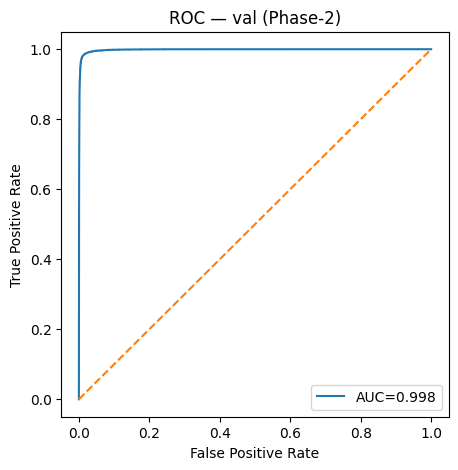

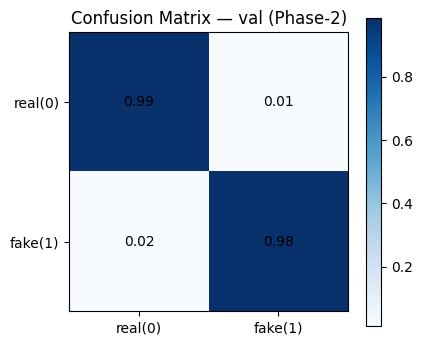

  saved predictions -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\val_preds_phase2.csv

              precision    recall  f1-score   support

     real(0)     0.9846    0.9856    0.9851     19787
     fake(1)     0.9855    0.9845    0.9850     19641

    accuracy                         0.9850     39428
   macro avg     0.9850    0.9850    0.9850     39428
weighted avg     0.9850    0.9850    0.9850     39428

  saved classification report -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\val_classification_report_phase2.csv


Eval test: 100%|████████████████████████████████████████████████| 2727/2727 [01:38<00:00, 27.56it/s]


[2025-09-05 17:01:44+0800] TEST — acc 0.9396 | AUC 0.9894 | F1 0.9424 | precision 0.9058 | recall 0.9822 | 10905 imgs in 99.0s (110.2 img/s)


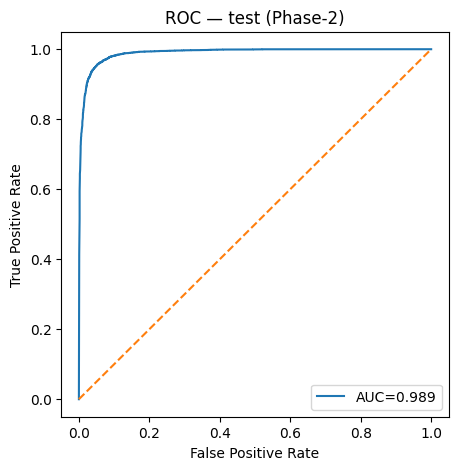

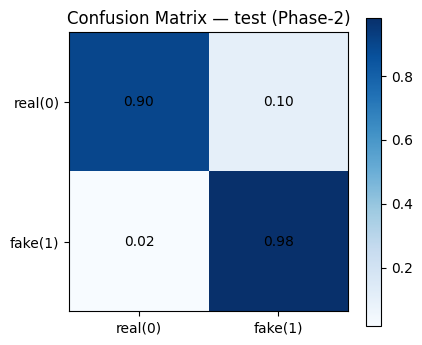

  saved predictions -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\test_preds_phase2.csv

              precision    recall  f1-score   support

     real(0)     0.9802    0.8964    0.9364      5413
     fake(1)     0.9058    0.9822    0.9424      5492

    accuracy                         0.9396     10905
   macro avg     0.9430    0.9393    0.9394     10905
weighted avg     0.9427    0.9396    0.9394     10905

  saved classification report -> c:\C's TARUMT\Artificial Intelligence\deepfakeDetection-mvitv2\outputs\predictions\test_classification_report_phase2.csv

[2025-09-05 17:01:45+0800] Done. Summary:
  VAL : {'acc': 0.9850360150147104, 'auc': 0.998352563245178, 'f1': 0.9849727471855738, 'precision': 0.9854747464451353, 'recall': 0.9844712591008604}
  TEST: {'acc': 0.939569005043558, 'auc': 0.9894025860163193, 'f1': 0.9424303310911156, 'precision': 0.9057934508816121, 'recall': 0.9821558630735615}


In [42]:
# === EVALUATION (Phase-2 best) — metrics, ROC, confusion matrix, CSV preds ===
from tqdm import tqdm as TQDM_TXT
import torch, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Uses your Phase-2 best checkpoint
best_ckpt = CKPT_DIR / train_cfg2["best_name"]
assert best_ckpt.exists(), f"Best checkpoint not found: {best_ckpt}"

# Load best weights
ckpt = torch.load(best_ckpt, map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.eval().to(device)
print(f"[{ts()}] Loaded best checkpoint: {best_ckpt}")

def eval_split(split_name, loader, manifest_csv):
    t0 = time.time()
    all_probs, all_labels = [], []
    phase_suffix = "phase2"

    with torch.no_grad():
        for step, (images, labels) in enumerate(TQDM_TXT(loader, desc=f"Eval {split_name}", ncols=100), 1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()
            logits = model(images)                      # [B, 2]
            probs1 = torch.softmax(logits, dim=1)[:,1]  # P(fake)
            all_probs.append(probs1.cpu())
            all_labels.append(labels.cpu())

            # heartbeat every ~3000 steps
            if step % 3000 == 0:
                print(f"[{ts()}] {split_name} step {step}/{len(loader)}", flush=True)

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    preds = (all_probs >= 0.5).astype("int64")
    acc   = (preds == all_labels).mean()

    if np.unique(all_labels).size >= 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        split_auc   = auc(fpr, tpr)
    else:
        fpr, tpr, split_auc = np.array([0,1]), np.array([0,1]), float("nan")

    f1  = f1_score(all_labels, preds, zero_division=0)
    pre = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    cm  = confusion_matrix(all_labels, preds)

    dt = time.time() - t0
    imgs = len(all_labels)
    print(
        f"[{ts()}] {split_name.upper()} — acc {acc:.4f} | AUC {split_auc:.4f} | F1 {f1:.4f} "
        f"| precision {pre:.4f} | recall {rec:.4f} | {imgs} imgs in {dt:.1f}s ({imgs/dt:.1f} img/s)"
    )

    # Save ROC
    fig_dir = FIG_DIR
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(5,5))
    if not np.isnan(split_auc):
        plt.plot(fpr, tpr, label=f"AUC={split_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {split_name} (Phase-2)")
    plt.legend(loc="lower right")
    roc_path = fig_dir / f"roc_{phase_suffix}_{split_name}.png"
    plt.savefig(roc_path, dpi=120, bbox_inches="tight")
    plt.show()   # <--- display inline
    plt.close()

    # Save confusion matrix (normalized)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm_norm, interpolation='nearest', cmap="Blues")
    plt.title(f"Confusion Matrix — {split_name} (Phase-2)")
    plt.colorbar()
    plt.xticks([0,1], ["real(0)","fake(1)"])
    plt.yticks([0,1], ["real(0)","fake(1)"])
    for (i,j), v in np.ndenumerate(cm_norm):
        plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    cm_path = fig_dir / f"cm_{phase_suffix}_{split_name}.png"
    plt.savefig(cm_path, dpi=120, bbox_inches="tight")
    plt.show()   # <--- display inline
    plt.close()

    # Save per-image predictions CSV
    df_manifest = pd.read_csv(manifest_csv)
    df_out = df_manifest.iloc[:len(all_probs)].copy()
    df_out["prob_fake"] = all_probs
    df_out["pred"] = preds
    preds_dir = cfg["project_root"] / "outputs" / "predictions"
    preds_dir.mkdir(parents=True, exist_ok=True)
    csv_path = preds_dir / f"{split_name}_preds_{phase_suffix}.csv"
    df_out.to_csv(csv_path, index=False)
    print(f"  saved predictions -> {csv_path}")

    # Print classification report (text)
    print("\n" + classification_report(all_labels, preds, target_names=["real(0)","fake(1)"], digits=4))
    
    # Generate dict instead of string
    report_dict = classification_report(all_labels, preds, target_names=["real(0)","fake(1)"], output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    # Save to CSV
    report_path = preds_dir / f"{split_name}_classification_report_{phase_suffix}.csv"
    df_report.to_csv(report_path, float_format="%.4f")
    print(f"  saved classification report -> {report_path}")

    return {"acc":acc, "auc":split_auc, "f1":f1, "precision":pre, "recall":rec}

# Evaluate on VAL
val_csv = cfg["project_root"] / "data" / "manifests" / "val.csv"
val_metrics = eval_split("val", val_loader, val_csv)

# Evaluate on TEST
test_csv = cfg["project_root"] / "data" / "manifests" / "test.csv"
test_metrics = eval_split("test", test_loader, test_csv)

print(f"\n[{ts()}] Done. Summary:")
print("  VAL :", val_metrics)
print("  TEST:", test_metrics)